In [3]:
import sys
import joblib
import os.path

import pandas as pd
import numpy as np
import scipy
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, ElasticNetCV
import matplotlib.pyplot as plt

import torch, gc
import plotnine as pn

import dataloader
import g2p_bayes_cov_skipcon as g2p_bayes_cov

### Load data via dataloader

In [4]:
trait = "LDL_direct"
embedding_type = "omics_pops" #choose from ['string', 'omics', 'pops', 'omics_pops', 'pops_exp', None]
genotype = "deepRVAT" #choose from ['pLoF', 'deepRVAT']
add_loeuf = False #add loeuf score as additional dimension to gene embedding
add_alpha_mis = False
add_gwas_hits = False
only_genebass_genes = False #restrict everything to genebass genes
extend_covariates = True #extend covariates with age**2, age:sex, age**2:sex 
normalize = True #z-score normalize covariates
version = "filteredv3" #dataset to use (filteredv2 has removed non-Caucasians)

(gt_train, gt_val, gt_test), (y_train, y_val, y_test), emb, gene_list, (id_train, id_val, id_test), (trait_measurement_train, trait_measurement_val, trait_measurement_test), (covariates_train, covariates_val, covariates_test) = dataloader.load_data(trait, embedding_type, add_loeuf=add_loeuf, add_alpha_mis=add_alpha_mis, add_gwas_hits=add_gwas_hits, only_genebass_genes=only_genebass_genes, extend_covariates=extend_covariates, normalize=normalize, version=version, genotype=genotype)

if embedding_type is None:
    emb = np.zeros(len(gene_list))

In [5]:
print(gt_train.shape, emb.shape)

(92352, 17517) (17517, 512)


In [6]:
len(gene_list)

17517

In [7]:
emb[:,-1]

array([ 2.18228361, -0.67447768,  2.1859231 , ...,  6.14925561,
        0.83932342, -0.10811951])

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Define/initialize model

In [9]:
gc.collect()
torch.cuda.empty_cache()

import importlib
importlib.reload(g2p_bayes_cov)

<module 'g2p_bayes_cov_skipcon' from '/data/nasif12/home_if12/lond/Code/geno2pheno/bayesG2P/scripts/g2p_bayes_cov_skipcon.py'>

In [10]:
args = {
    "trait": trait,
    "embedding_type": embedding_type,
    "add_loeuf": add_loeuf,
    "add_alpha_mis": add_alpha_mis,
    "add_gwas_hits": add_gwas_hits,
    "skip_con": False,
    "normalize_embeddings": False, #z-score normalize embeddings
    "embedding_dim": emb.shape[1], #dimension of embedding
    "n_genes": len(gene_list), #number of genes
    "n_samples": len(y_train), #number of training samples
    "learning_rate": 0.001, #lr for Adam optimizer 
    "epochs": 15, #Number of epochs to train
    "nonlinearity": "softplus", #choose from ['relu', 'silu', 'elu', 'gelu', 'softplus']
    "weight_decay": 0, #L2 penalty on trainable parameters
    "batch_size": 8*1024,
    "n_hidden": 3, #number of hidden layers in f(E)
    "hidden_dim": 8, #number of neurons in each hidden layer of f(E)
    "last_layer_bias": -7, #initialization of bias term of last layer in f(E)
    "early_stopping": False, #If True, stops training if val r2 is lower than covariate r2 for >5 epochs
    "y_var_init": y_train.var(), #initialization of variance of y
    "alpha_L1_fE": 0, #L1 penalty weighting of f(E)
    "base_var_init": 1e-5, #Constant variance value to be added to f(E)
}

# Generate the model.
# g2p_cov_model = g2p_bayes_cov.G2P_Model(args["embedding_dim"], covariates_train.shape[1], n_hidden=args["n_hidden"], hiddem_dim=args["hidden_dim"], last_layer_bias=args["last_layer_bias"], nonlinearity=args["nonlinearity"], y_var_init=args["y_var_init"], base_var=args["base_var"], n_genes=args["n_genes"], add_loeuf=args["add_loeuf"], add_alpha_mis=args["add_alpha_mis"], add_gwas_hits=args["add_gwas_hits"], skip_con=args["skip_con"], device=device)

g2p_cov_model = g2p_bayes_cov.G2P_Model(args["embedding_dim"], covariates_train.shape[1], n_hidden=args["n_hidden"], hiddem_dim=args["hidden_dim"], skip_con=args["skip_con"], last_layer_bias=args["last_layer_bias"], nonlinearity=args["nonlinearity"], y_var_init=args["y_var_init"], base_var_init=args["base_var_init"], n_genes=args["n_genes"], device=device)


g2p_cov_model = g2p_cov_model.to(device)

print("Number of trainable parameters in model:", sum(p.numel() for p in g2p_cov_model.parameters() if p.requires_grad))

Number of trainable parameters in model: 4334


### Fit model

In [11]:
g2p_cov_model.fit_model(gt_train, covariates_train, trait_measurement_train, 
                        emb, 
                        args, 
                        G_val=gt_val, C_val=covariates_val, y_val=trait_measurement_val,
                        gene_list=gene_list,
                        fast=False, #Compute posterior distribution after every epoch. Necessary for r2. 
                        device=device
)

r2_score(trait_measurement_test, gt_test @ g2p_cov_model.best_r2_trainval_mean_beta + covariates_test @ g2p_cov_model.best_r2_gamma + g2p_cov_model.best_r2_intercept)

Covariates r2 on val: 0.2024944240341271
After epoch 0: Train loss: 10415.81483, Validation loss: 10141.07306, Train r2: 0.219, Val r2: 0.20361, Epoch time: 10.09s
After epoch 1: Train loss: 10414.42776, Validation loss: 10140.51858, Train r2: 0.22023, Val r2: 0.20518, Epoch time: 7.29s
After epoch 2: Train loss: 10406.84926, Validation loss: 10126.55348, Train r2: 0.22413, Val r2: 0.20841, Epoch time: 7.32s
After epoch 3: Train loss: 10400.76581, Validation loss: 10123.96086, Train r2: 0.22665, Val r2: 0.21025, Epoch time: 7.34s
After epoch 4: Train loss: 10394.58542, Validation loss: 10115.32774, Train r2: 0.22754, Val r2: 0.21046, Epoch time: 7.3s
After epoch 5: Train loss: 10386.47594, Validation loss: 10113.57503, Train r2: 0.22809, Val r2: 0.2104, Epoch time: 7.29s
After epoch 6: Train loss: 10382.86713, Validation loss: 10112.39911, Train r2: 0.22813, Val r2: 0.21037, Epoch time: 7.33s
After epoch 7: Train loss: 10381.27629, Validation loss: 10111.93371, Train r2: 0.22796, Val r

0.21286968707633724

### Model analysis

In [47]:
g2p_cov_model.best_r2_base_var, g2p_cov_model.best_loss_base_var

(array([-0.00082089], dtype=float32), array([-0.00011429], dtype=float32))

In [51]:
g2p_cov_model.var_pred_model.layers[-2].bias.item()

-6.960536956787109

<Axes: >

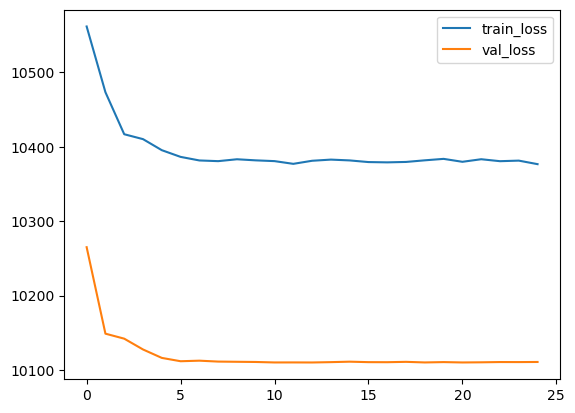

In [10]:
pd.DataFrame({"train_loss": g2p_cov_model.epoch_loss_list, "val_loss": g2p_cov_model.val_list}).plot()

<Axes: >

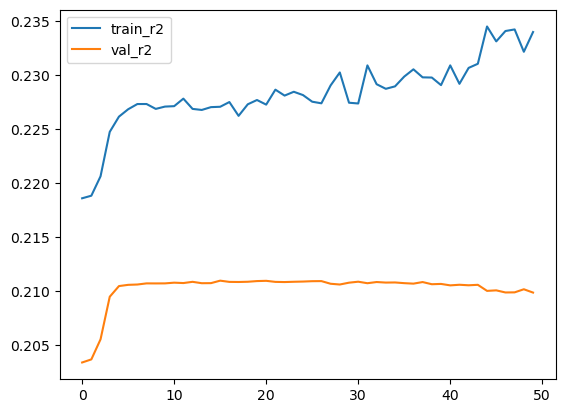

In [17]:
pd.DataFrame({"train_r2": g2p_cov_model.train_r2_list, "val_r2": g2p_cov_model.val_r2_list}).plot()

#### r2 on test dataset:

In [16]:
print('Best loss: ', r2_score(trait_measurement_test, gt_test @ g2p_cov_model.best_loss_trainval_mean_beta + covariates_test @ g2p_cov_model.best_loss_gamma + g2p_cov_model.best_loss_intercept))
print('Best R2: ', r2_score(trait_measurement_test, gt_test @ g2p_cov_model.best_r2_trainval_mean_beta + covariates_test @ g2p_cov_model.best_r2_gamma + g2p_cov_model.best_r2_intercept))

Best loss:  0.2122856894844629
Best R2:  0.21236277225396305


#### Replication of gene discovery

In [15]:
genebass_phenocode_dict = pd.read_csv("/s/project/rep/processed/trait_associations_v5/ukbb_wes_200k/PRS_score_mapping.csv")[["phenotype", "genebass_phenocode"]].set_index("genebass_phenocode")["phenotype"].to_dict()
genebass_phenocode_dict = {v: k for k, v in genebass_phenocode_dict.items()}
genebass_phenocode_dict["LDL_direct"] = "30780"

#genebass_results = pd.read_parquet("/s/project/rep/processed/genebass/500k/results.parquet", columns=["annotation", "gene_id", "phenocode", "BETA_Burden", "SE_Burden", "Pvalue_Burden"]).query(f"phenocode=='{genebass_phenocode_dict[trait]}'").rename(columns={"Pvalue_Burden": "PVAL_Burden"})

genebass_df = pd.read_parquet('/s/project/uk_biobank/processed/g2p/modelling/replication_set/genebass_pvals_500k_selected_traits.parquet', engine='pyarrow').query("(significant_burden and keep_gene_burden) or (significant_skato and keep_gene_skato)")#.query("annotation=='pLoF'")
genebass_df = genebass_df[genebass_df["phenocode"].isin([genebass_phenocode_dict[trait]])]
#genebass_df = pd.merge(genebass_df, genebass_results, how="left", on=["annotation", "gene_id", "phenocode"])
genebass_df["association"] = genebass_df["gene_id"] + "_" + genebass_df["phenocode"]

backman_df = pd.read_excel('/s/project/uk_biobank/processed/g2p/modelling/replication_set/41586_2021_4103_MOESM5_ESM.xlsx', sheet_name='SD2', engine='openpyxl')[['Marker type', 'Gene', 'UKB detailed trait name', 'Marker']]
backman_df = backman_df[backman_df['Marker type'] == 'Burden']
backman_df["phenocode"] = backman_df["UKB detailed trait name"].str.split("_", expand=True)[0]
backman_pheno = [genebass_phenocode_dict[trait]]
markers = ['M1.1', 'M3.1']
backman_df = backman_df.query('phenocode == @backman_pheno and Marker in @markers')
protein_coding_genes_df = pd.read_parquet("/s/project/uk_biobank/processed/g2p/modelling/replication_set/protein_coding_genes.parquet")

backman_df = pd.merge(backman_df, protein_coding_genes_df, left_on="Gene", right_on="gene_name")
backman_df["gene_id"] = backman_df["gene"].str.split(".", expand=True)[0]
backman_df["association"] = backman_df["gene_id"] + "_" + backman_df["phenocode"]

replication_association_set = set(genebass_df["association"].to_list() + backman_df["association"].to_list())
replication_gene_set = {a.split("_")[0] for a in replication_association_set}

In [50]:
ols_full_pLoF_df = pd.read_parquet(f"/s/project/uk_biobank/processed/g2p/modelling/ols_{genotype}/filteredv2_ols_{genotype}_full_{trait}.pq").sort_values("neglog_pval", ascending=False).reset_index().rename(columns={"index": "gene_id"})
ols_full_pLoF_df["rank"] = ols_full_pLoF_df.index + 1
ols_full_pLoF_df["significant"] = ols_full_pLoF_df["pval"] < 0.05/len(ols_full_pLoF_df)
ols_full_pLoF_df["replicated"] = ols_full_pLoF_df["gene_id"].isin([a.split("_")[0] for a in replication_association_set])
ols_full_pLoF_df["n_replicated"] = ols_full_pLoF_df["replicated"].cumsum()

ols_train_full_pLoF_df = pd.read_parquet(f"/s/project/uk_biobank/processed/g2p/modelling/ols_{genotype}/filteredv2_ols_{genotype}_train_full_{trait}.pq").sort_values("neglog_pval", ascending=False).reset_index().rename(columns={"index": "gene_id"})
ols_train_full_pLoF_df["rank"] = ols_train_full_pLoF_df.index + 1
ols_train_full_pLoF_df["significant"] = ols_train_full_pLoF_df["pval"] < 0.05/len(ols_train_full_pLoF_df)
ols_train_full_pLoF_df["replicated"] = ols_train_full_pLoF_df["gene_id"].isin([a.split("_")[0] for a in replication_association_set])
ols_train_full_pLoF_df["n_replicated"] = ols_train_full_pLoF_df["replicated"].cumsum()
ols_train_full_pLoF_df["model"] = ols_train_full_pLoF_df["model"] + "_train"

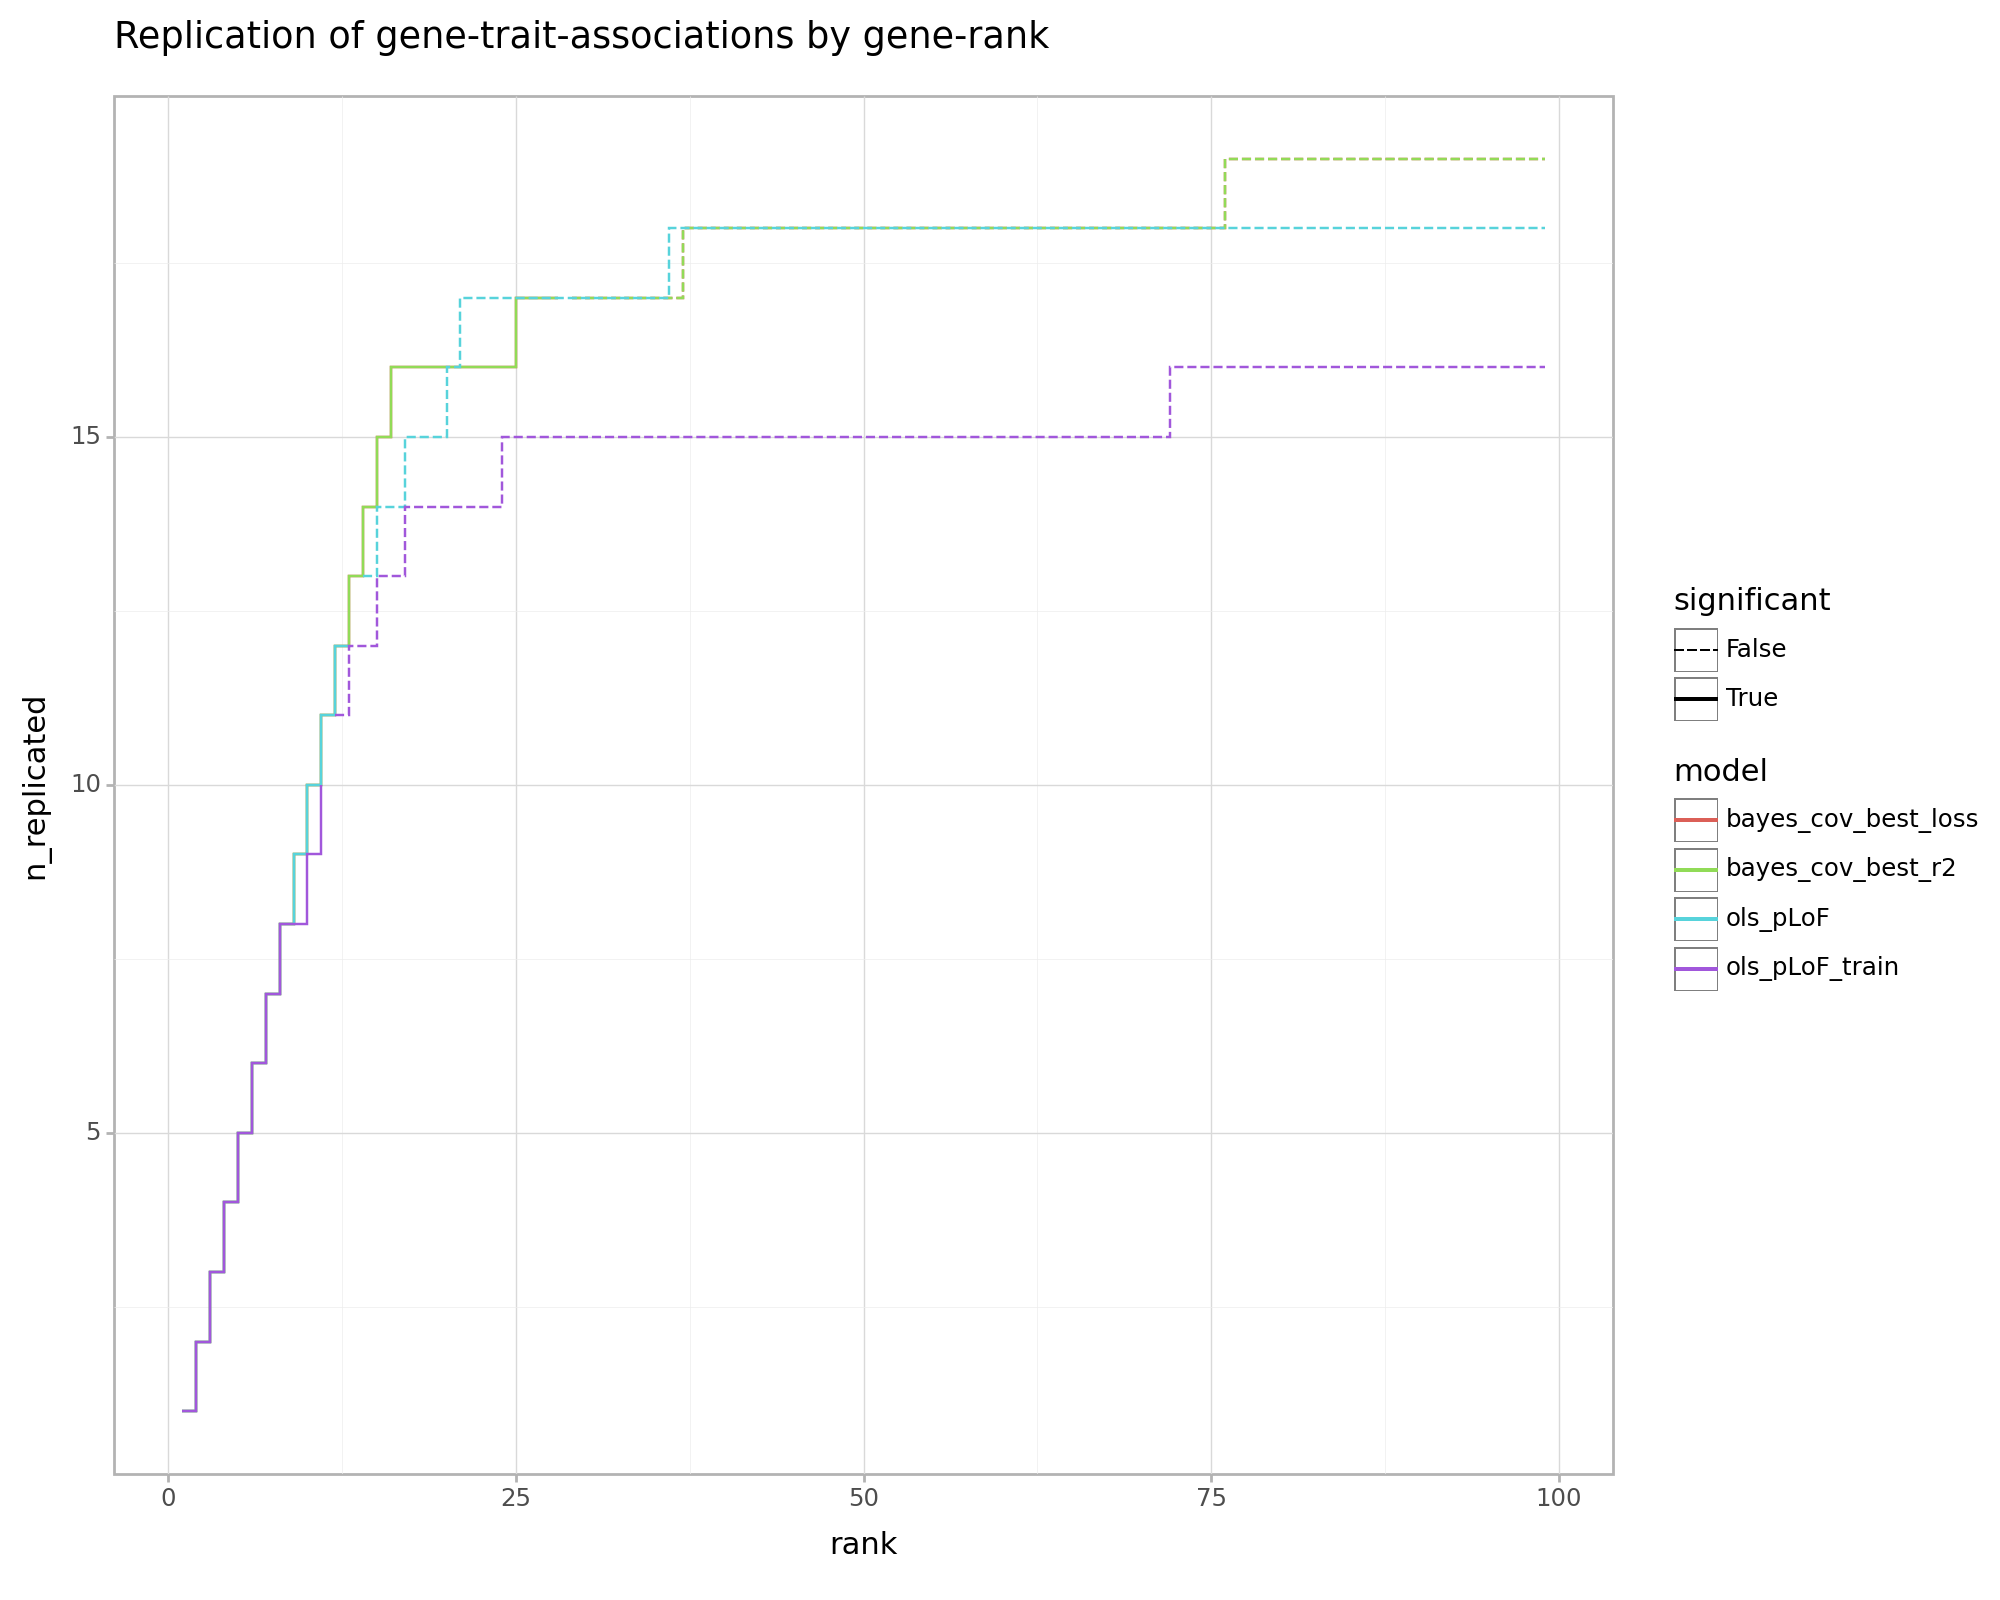

<Figure Size: (1000 x 800)>

In [74]:
mean_betas_cov_loss_recomp_df = pd.DataFrame({"mean_beta": g2p_cov_model.best_loss_trainval_mean_beta, "var_beta": g2p_cov_model.best_loss_trainval_var_beta}, index=gene_list).reset_index()
mean_betas_cov_loss_recomp_df["model"] = "bayes_cov_best_loss"
mean_betas_cov_loss_recomp_df["pval"] = scipy.stats.norm.cdf(0, mean_betas_cov_loss_recomp_df["mean_beta"], np.sqrt(mean_betas_cov_loss_recomp_df["var_beta"]))
mean_betas_cov_loss_recomp_df["pval"] = 2 * np.minimum(mean_betas_cov_loss_recomp_df["pval"], 1 - mean_betas_cov_loss_recomp_df["pval"])
mean_betas_cov_loss_recomp_df["significant"] = mean_betas_cov_loss_recomp_df["pval"]<0.05
mean_betas_cov_loss_recomp_df.loc[mean_betas_cov_loss_recomp_df['pval']==0, 'pval'] = 1e-30
mean_betas_cov_loss_recomp_df["neglog_pval"] = -np.log10(mean_betas_cov_loss_recomp_df["pval"])
mean_betas_cov_loss_recomp_df["std_err"] = np.sqrt(mean_betas_cov_loss_recomp_df["var_beta"])
mean_betas_cov_loss_recomp_df["replicated"] = (mean_betas_cov_loss_recomp_df["index"]).isin(replication_gene_set)
mean_betas_cov_loss_recomp_df["rank"] = mean_betas_cov_loss_recomp_df.groupby("model")["neglog_pval"].rank(method="first", ascending=False)
mean_betas_cov_loss_recomp_df = mean_betas_cov_loss_recomp_df.sort_values(["model", "rank"])
mean_betas_cov_loss_recomp_df["n_replicated"] = mean_betas_cov_loss_recomp_df.groupby('model')['replicated'].transform(pd.Series.cumsum)

mean_betas_cov_recomp_df = pd.DataFrame({"mean_beta": g2p_cov_model.best_r2_trainval_mean_beta, "var_beta": g2p_cov_model.best_r2_trainval_var_beta}, index=gene_list).reset_index()
mean_betas_cov_recomp_df["model"] = "bayes_cov_best_r2"
mean_betas_cov_recomp_df["pval"] = scipy.stats.norm.cdf(0, mean_betas_cov_recomp_df["mean_beta"], np.sqrt(mean_betas_cov_recomp_df["var_beta"]))
mean_betas_cov_recomp_df["pval"] = 2 * np.minimum(mean_betas_cov_recomp_df["pval"], 1 - mean_betas_cov_recomp_df["pval"])
mean_betas_cov_recomp_df["significant"] = mean_betas_cov_recomp_df["pval"]<0.05
mean_betas_cov_recomp_df.loc[mean_betas_cov_recomp_df['pval']==0, 'pval'] = 1e-30
mean_betas_cov_recomp_df["neglog_pval"] = -np.log10(mean_betas_cov_recomp_df["pval"])
mean_betas_cov_recomp_df["std_err"] = np.sqrt(mean_betas_cov_recomp_df["var_beta"])
mean_betas_cov_recomp_df["replicated"] = (mean_betas_cov_recomp_df["index"]).isin(replication_gene_set)
mean_betas_cov_recomp_df["rank"] = mean_betas_cov_recomp_df.groupby("model")["neglog_pval"].rank(method="first", ascending=False)
mean_betas_cov_recomp_df = mean_betas_cov_recomp_df.sort_values(["model", "rank"])
mean_betas_cov_recomp_df["n_replicated"] = mean_betas_cov_recomp_df.groupby('model')['replicated'].transform(pd.Series.cumsum)

plot = (
    pn.ggplot(pd.concat([mean_betas_cov_recomp_df, mean_betas_cov_loss_recomp_df, ols_full_pLoF_df, ols_train_full_pLoF_df]).query(f"rank<100"), pn.aes(y="n_replicated", x="rank", color="model", linetype="significant"))
    + pn.geom_step()
    + pn.scales.scale_linetype_manual(values={True: "solid", False: "dashed"})
    + pn.theme_light()
    + pn.theme(figure_size=(10, 8))
    + pn.labels.ggtitle(f"Replication of gene-trait-associations by gene-rank")
)
plot